<a href="https://colab.research.google.com/github/variableVG/CV_project/blob/master/03_Resize_pictures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Data and images

In [2]:
! pip install gdown
! mkdir -p /content/pic/
! gdown -O /content/pic/all_pictures.tar "1B2TxGvEP-tEhtgCu2-nccUqr4Tzit0e5"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1B2TxGvEP-tEhtgCu2-nccUqr4Tzit0e5
To: /content/pic/all_pictures.tar
100% 1.45G/1.45G [00:08<00:00, 179MB/s]


In [3]:
import tarfile
try: 
  tar = tarfile.open('/content/pic/all_pictures.tar')
  tar.extractall(path='/content/pic')
  tar.close()
except:
  print("Pictures could not be extracted")

In [4]:
! mv /content/pic/content/drive/MyDrive/pic/* /content/pic/
! rmdir /content/pic/content

rmdir: failed to remove '/content/pic/content': Directory not empty


In [5]:
path_to_pictures = '/content/pic/'
path_to_dataset = '/content/drive/MyDrive/Colab Notebooks/CVNLP/dataset_faces.csv'

In [6]:
import pandas as pd
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import torch

In [7]:
df = pd.read_csv(path_to_dataset)

In [8]:
df.head()

,filename,age,gender,ethnicity
0,36_1_1_20170116022026435.jpg,36,1,1
1,36_1_1_20170116153744623.jpg,36,1,1
2,36_1_1_20170116161213859.jpg,36,1,1
3,36_1_1_20170116173257960.jpg,36,1,1
4,36_1_1_20170116161709695.jpg,36,1,1


In [9]:
df.shape

(24105, 4)

# Reduce dataset

Here I have reduced the number of samples, since my computer crashed continuously (also in google collabs I ran out of RAM). To do that, I have reduced the number of samples based on the age and ethnicity of the people in the photographs, since according to Jupyter Notebook number 2, the dataset was unbalanced. This can also be changed in the future. 

In [10]:
# I can just load up to 8890 pictures before my RAM crashes
# Therefore I drop about 12.000 pictures of people with ethnicity number 1 and/or
# people with less than 1 year, since the df is imbalanced with a lot of babys
# and white people. 

df = df.drop(df[df['age'] == 22].sample(frac=.3).index) #Select randomly 30% of the samples where age is 22 and drop them
df = df.drop(df[df['age'] == 23].sample(frac=.4).index) #Select randomly 40% of the samples where age is 23 and drop them
df = df.drop(df[df['age'] == 24].sample(frac=.6).index)
df = df.drop(df[df['age'] == 25].sample(frac=.6).index)
df = df.drop(df[df['age'] == 26].sample(frac=.90).index)
df = df.drop(df[df['age'] == 27].sample(frac=.6).index)
df = df.drop(df[df['age'] == 28].sample(frac=.7).index)
df = df.drop(df[df['age'] == 29].sample(frac=.5).index)
df = df.drop(df[df['age'] == 30].sample(frac=.5).index)
df = df.drop(df[df['age'] == 32].sample(frac=.5).index)
df = df.drop(df[df['age'] == 35].sample(frac=.7).index)
df = df.drop(df[df['age'] == 36].sample(frac=.3).index)
df = df.drop(df[df['age'] == 40].sample(frac=.3).index)
df = df.drop(df[df['age'] == 45].sample(frac=.3).index)
df = df.drop(df[df['age'] <= 1].sample(frac=.85).index)
df = df.drop(df[df['age'] == 2].sample(frac=.45).index)
df = df.drop(df[df['ethnicity'] == 0].sample(frac=.5).index)

df = df.drop(df.sample(frac=.9).index) # Randomly drop 90% of the samples in dataset

In [11]:
df.shape

(1251, 4)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


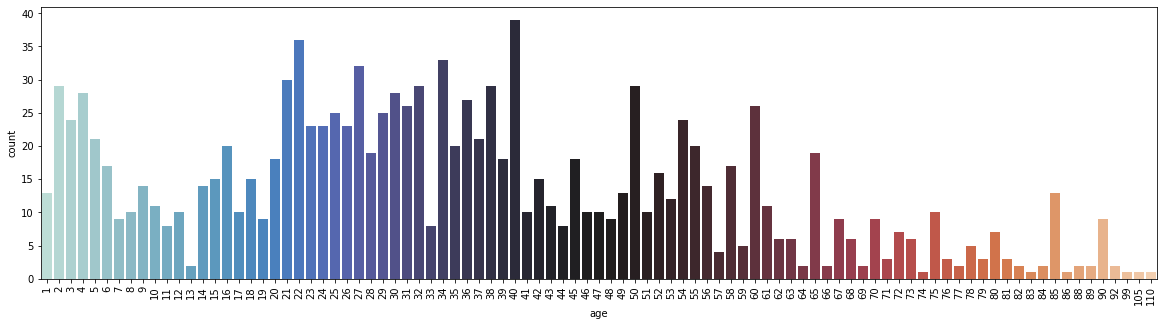

In [12]:
# Show age distribution
import seaborn as sns
plt.figure(figsize=(20,5))
ax = sns.countplot(df['age'], palette='icefire')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


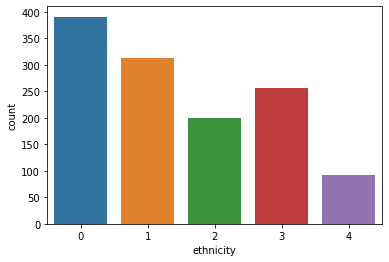

In [13]:
# Show ethnicity distribution
sns.countplot(df['ethnicity'])

In [14]:
# WARNING: This might take long
from tqdm import tqdm
from pathlib import Path
images = []

for image in tqdm(df['filename']):
  path = path_to_pictures + image
  try: 
    img = Image.open(path).convert('RGB') # I use that to make sure all the pictures are RGB
    images.append(img)
    #img = np.array(img)
  except FileNotFoundError as e:
    print(e)
  

100%|██████████| 1251/1251 [00:18<00:00, 67.71it/s]


In [15]:
print(images[0])

<PIL.Image.Image image mode=RGB size=738x1107 at 0x7F9B797E1410>


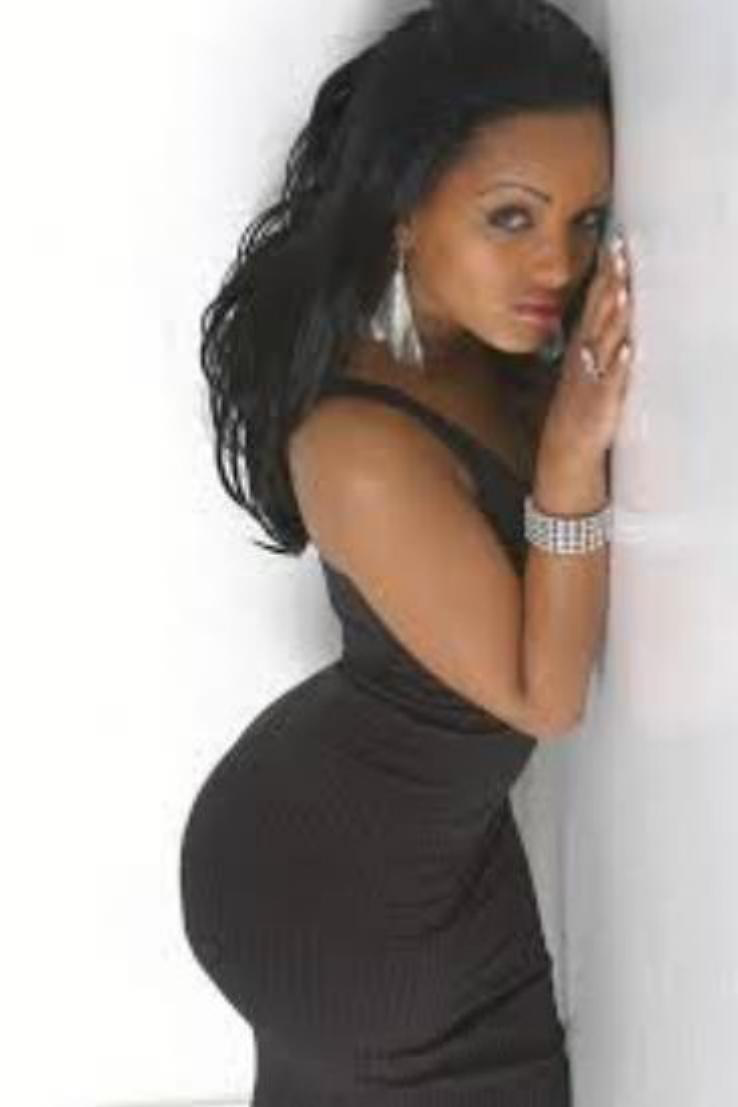

In [16]:
images[0]

# Resize Pictures

In this notebook we are going to resize all the images to have them in a size that is manageable for our RAM. In addition, all images will have a homogeneous size, which can be beneficial during algorithm training.

### Investigate optimal picture size

In [17]:
# Investigate size of the first 5 pictures:
pixels_in_x_axis = []
pixels_in_y_axis = []

for idx, img in enumerate(images):
  img_array = np.array(img)
  pixels_in_x_axis.append(img_array.shape[0])
  pixels_in_y_axis.append(img_array.shape[1])
  if idx < 5: 
    print(f"Image {idx} has shape {img_array.shape}")

Image 0 has shape (1107, 738, 3)
Image 1 has shape (1067, 766, 3)
Image 2 has shape (735, 1106, 3)
Image 3 has shape (1131, 722, 3)
Image 4 has shape (819, 994, 3)


In [18]:
pixels_in_x_axis = pd.Series(pixels_in_x_axis)
pixels_in_y_axis = pd.Series(pixels_in_y_axis)

print(f"Mean size for pictures is ({pixels_in_x_axis.mean()} , {pixels_in_y_axis.mean()})")
print(f"Smaller size for x is {pixels_in_x_axis.min()} pixel and for y {pixels_in_y_axis.min()} pixels.")

Mean size for pictures is (654.6402877697842 , 629.074340527578)
Smaller size for x is 69 pixel and for y 99 pixels.


### Set image size

In [19]:
img_size = (128, 128)

### Resize images

In [20]:
resized_images = []
for img in images:
  resized_img = T.Resize(size=img_size) (img)
  resized_images.append(resized_img)

### Check and save final image size

In [21]:
! mkdir -p /content/small_pics

In [22]:
# Check sizes and save the small pictures in a new path:
path_to_small_pic = '/content/small_pics/'

for idx, img in enumerate(resized_images):
  img_array = np.array(img)
  im = Image.fromarray(img_array)
  image_name = path_to_small_pic + df['filename'].iloc[idx]
  im.save(image_name)    

In [23]:
print(resized_images[0])

<PIL.Image.Image image mode=RGB size=128x128 at 0x7F9B797E1910>


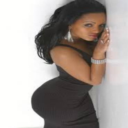

In [24]:
resized_images[0]

# Upload tar file

In [25]:
df.shape

(1251, 4)

In [26]:
# Upload reduced dataset
df.to_csv('/content/drive/MyDrive/Colab Notebooks/CVNLP/dataset_faces_small.csv', index=False)

In [27]:
# Save all pictures in a .tar file and upload it to GoogleDrive
import tarfile
path = '/content/drive/MyDrive/Colab Notebooks/CVNLP/small_pictures.tar'
tar = tarfile.open(path, "w")

from tqdm import tqdm
for name in  tqdm(df['filename']):
  new_path = path_to_small_pic + name
  tar.add(new_path)
tar.close()

100%|██████████| 1251/1251 [00:00<00:00, 4592.67it/s]
